In [ ]:
# default_exp animations

# Animations
> This module contains the utilities needed to generate animations of how an `optimize` object progresses on a given `Ifunction` surface. This supports both `derivative-based` (like `SGD`, `Adam`, etc..) or `derivative-free` optimization methods

In [ ]:
#hide
%load_ext autoreload
%autoreload 2

In [ ]:
#exporti
import matplotlib.animation as animation
from matplotlib import pyplot as plt
from IPython.display import HTML, display
from itertools import cycle
from typing import List, Union
from cycler import cycler
from functools import partial
from mpl_toolkits.mplot3d.art3d import Line3D, Poly3DCollection
import numpy as np
from itertools import islice

from optimisations.graphics import plot_function
from optimisations.graphics import rotate
from optimisations.optimizers import optimize

interactive(children=(IntSlider(value=45, description='azimuth', max=135, min=-45), IntSlider(value=45, descri…

In [ ]:
#export
from optimisations.renderers import Figure, decorate_with_derivative_based_plot

renderers = {
    'sgd': decorate_with_derivative_based_plot,
    'rmsprop': decorate_with_derivative_based_plot,
    'adamax': decorate_with_derivative_based_plot,
    'adam': decorate_with_derivative_based_plot,
    'momentum': decorate_with_derivative_based_plot,
#     'ga': decorate_with_genetic_algo_plot
}


def single_frame(i, optimisations: Union[optimize, List[optimize]], figure: Figure, renderers: dict):
    # make sure we have a list of optimizers going forward
    optimisations = [optimisations] if isinstance(optimisations, optimize) else optimisations

    figure.ax_3d.clear()
    figure.ax_2d.clear()
    
    assert len(optimisations) >= 1, f"We need at least one optimisation to animate, but {len(optimisations)} given."
    # assert all functions to optimise have the same definition

    plot_function(optimisations[0].function, angle=figure.angle, fig=figure.fig, ax_3d=figure.ax_3d, ax_2d=figure.ax_2d, contour_log_scale=figure.contour_log_scale, azimuth_3d=figure.azimuth_3d, zoom_factor=figure.zoom_factor)
    
    for i, optimisation in enumerate(optimisations):
        if optimisation.optimizer_name not in renderers and i <= 1:  # only show this error once
            print(f"Couldn't find a propper renderer for function named {optimisation.optimizer_name}. Will try to use the default `decorate_with_derivative_based_plot` method.")
        
        optimisation.update()
        
        renderer = renderers.get(optimisation.optimizer_name, decorate_with_derivative_based_plot)
        points = np.array([np.asarray(optimisation._get_params(state)) for state in optimisation.history])
        points = [(x, y, optimisation.function(x, y)) for x, y in points]

        renderer(optimisation.optimizer_name, points, figure)

    figure.ax_2d.plot()
    print(".", end ="")

.

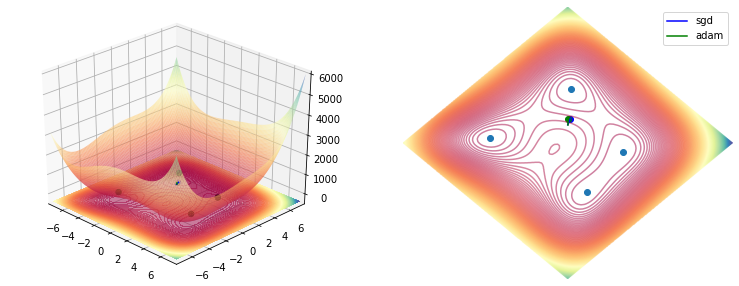

In [ ]:
from optimisations.optimizers import optimize_multi
from jax.experimental.optimizers import sgd, adam
from optimisations.functions import himmelblau

function = himmelblau()

figure = Figure(
    fig=plt.figure(figsize=(13,5)), 
    contour_log_scale=False, 
    angle=45-90, 
    zoom_factor=-0.5
).for_function(function)


single_frame(
    0,
    optimize_multi(function)
        .using([
            (sgd(step_size=0.01), "sgd", True),
            (adam(step_size=0.3), "adam", True),
        ])
        .start_from([-1., 1.])
        .tolist(),
    figure=figure,
    renderers=renderers
);

In [ ]:
#export
def animate(optimisations: Union[optimize, List[optimize]], figure: Figure=None, renderers=renderers, frames=20, interval=50, output='mp4'):
    optimisations = [optimisations] if isinstance(optimisations, optimize) else optimisations
    
    assert len(optimisations) >= 1, f"We need at least one optimisation to animate, but {len(optimisations)} given."
    
    unique_objective_functions = {optimisation.function for optimisation in optimisations}
    assert len(unique_objective_functions) == 1, f"We were expecting that all the optimisations would be running over the same objective function but we actually have {len(unique_objective_functions)}, namely {unique_objective_functions}. Please use only one!"
    
    if figure is None:
        figure=Figure(
            fig=plt.figure(figsize=(13,5)), 
            contour_log_scale=False, 
            angle=45,
        )
        
    figure = figure.for_function(optimisations[0].function)
    
    animator = animation.FuncAnimation(figure.fig, partial(single_frame, figure=figure, renderers=renderers), fargs=(optimisations,), frames=frames, interval=interval, blit=False)
    
    if output == 'mp4':
        video = animator.to_html5_video()
    elif output == 'js':
        video = animator.to_jshtml()
    else:
        raise ValueError(f"Provided output type {output} is unknown. Use one of 'mp4' or 'js'")
    
    display(HTML(video))
    plt.close()

    return video

> Note: The generation of the function is quite slow, as it doesn't use the `matplotlib`s `set_data` &co functions. For simplicity it generates new plots for each new frame. Since this is not intended to be used in real time, this is good enough for once-in-a-while generation.

In [ ]:
from jax.experimental.optimizers import sgd

animate(
    optimize_multi(himmelblau())
        .using([
            (sgd(step_size=0.01), "sgd", True),
            (adam(step_size=0.3), "adam", True),
        ])
        .start_from([-1., 1.])
        .tolist(),
    frames=20,
    interval=50,
    figure=Figure(
        fig=plt.figure(figsize=(13,5)), 
        contour_log_scale=False, 
        angle=45-90, 
        zoom_factor=-0.5
    )
);

.....................

## Usage examples

Basic usage of the `animate` function for a single `optimize` object (in this case `JAX`s `sgd` implementation)

In [ ]:
from jax.experimental.optimizers import sgd, adam
from optimisations.functions import saddle_point
from optimisations.optimizers import optimize_multi

animate(
    optimize(saddle_point())
        .using(sgd(step_size=0.3), name="sgd")
        .start_from([0.0003, 0.01]),
    frames=7
);

........

Usage for a concurrent optimization animation

In [ ]:
from jax.experimental.optimizers import sgd, adam, rmsprop, adagrad, nesterov

function = saddle_point()
animate(
    optimize_multi(function)
        .using([
            (sgd(step_size=0.1), "sgd", True),
            (adam(step_size=0.01), "adam", True),
            (rmsprop(step_size=0.01), "rmsprop", True),
            (adagrad(step_size=0.1), "adagrad", True),
            (nesterov(mass=0.1, step_size=0.1), "nesterov", True),
        ])
        .start_from([-0.0003, -0.01])
        .tolist(),
    frames=10,
    interval=50,
    figure=Figure(
        fig=plt.figure(figsize=(13,5)), 
        contour_log_scale=False,
    ).for_function(function)
);

/Users/cristi/Applications/GitHub/optimisations/optimisations/graphics.py:200: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax_2d = fig.add_subplot(1, 2, 2) if ax_2d is None else ax_2d


...........